# Exploratory Data Analysis (EDA)

Cel to zrozumienie struktury danych, rozkładu ocen dla jakości odpowiedzi i właściwości tekstowych, które mogą wpływać na skuteczność tworzonych później modeli NLP.

Notebooki korzystają z lokalnie przetworzonych danych, czego potrzebowałem z racji swojej aktualnej sytuacji, którą opisałem mejlowo. Przy okazji analiza jest powtarzalna, a repo leciutkie.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dla ułtwienia styl wizualizacji typowy dla matplotlib
plt.style.use("seaborn-v0_8")

# Wczytanie danych

In [10]:
train_df = pd.read_parquet("../data/processed/train.parquet")
val_df = pd.read_parquet("../data/processed/val.parquet")
test_df = pd.read_parquet("../data/processed/test.parquet")

#na potrzeby analizy
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df.head()

,id,question,instructor_answer,student_answer,score_grader_1,score_grader_2,score_avg,input_text,label,label_name
0,E11.Q03.A29,How are objects initialized when they are crea...,By using constructors.,obj. are initialized by the variables that cal...,7.5,2.0,2.5,How are objects initialized when they are crea...,0,low
1,E02.Q04.A18,When does C++ create a default constructor?,"If no constructor is provided, the compiler pr...",when no user-defined constructor exists,5.0,5.0,5.0,When does C++ create a default constructor? [S...,2,high
2,E07.Q01.A18,What is a linked list?,A collection of elements that can be allocated...,a series of structures containing data items a...,5.0,4.0,4.5,What is a linked list? [SEP] a series of struc...,2,high
3,E06.Q04.A11,How can an array be addressed in pointer/offse...,By initializing a pointer to point to the firs...,you can have a pointer to the front of the arr...,5.0,5.0,5.0,How can an array be addressed in pointer/offse...,2,high
4,E08.Q07.A18,What operations would you need to perform to f...,Pop all the elements and store them on another...,"createStack, push, isEmpty, pop, and a boolean...",4.0,2.0,3.0,What operations would you need to perform to f...,1,mid


In [11]:
""" 
info o pełnym datasecie;

"""
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2273 entries, 0 to 2272
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2273 non-null   object 
 1   question           2273 non-null   object 
 2   instructor_answer  2273 non-null   object 
 3   student_answer     2273 non-null   object 
 4   score_grader_1     2273 non-null   float32
 5   score_grader_2     2273 non-null   float32
 6   score_avg          2273 non-null   float32
 7   input_text         2273 non-null   object 
 8   label              2273 non-null   int64  
 9   label_name         2273 non-null   object 
dtypes: float32(3), int64(1), object(6)
memory usage: 151.1+ KB


Co ciekawe, skale dla score_avg (0-5) różnią się od score_grader_1 i score_grader_2 (0-10), 
co należało uwzględnić przy tworzeniu rankingu w algorytmie w src/data.py

In [12]:
full_df["score_avg"].describe()

count    2273.000000
mean        4.183898
std         1.096596
min         0.000000
25%         3.500000
50%         4.500000
75%         5.000000
max         5.000000
Name: score_avg, dtype: float64

Na podstawie analizy skali `score_avg` (0–5) przyjęto następującą
definicję klas jakości:

- **low**: 0–2 – odpowiedź błędna lub bardzo słaba
- **mid**: 3 – odpowiedź częściowo poprawna
- **high**: 4–5 – odpowiedź dobra lub bardzo dobra (najczęstsza)

# Rozkład ocen

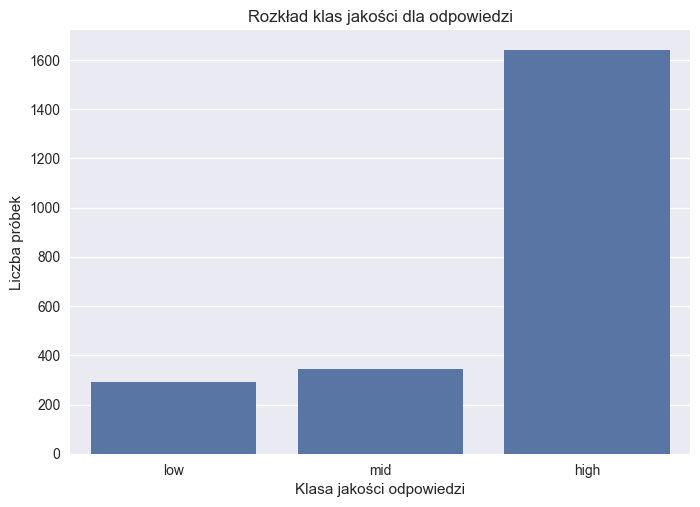

In [13]:
# rozkład klas odp
sns.countplot(data=full_df, 
            x="label_name",
            order=["low", "mid", "high"]
)
plt.title("Rozkład klas jakości dla odpowiedzi")
plt.xlabel("Klasa jakości odpowiedzi")
plt.ylabel("Liczba próbek")
plt.show()

Większość odpowiedzi jest "akceptowalna/dobra" czyli o jakości "high".
Z dydaktycznego pkt widzenia ma to realistyczne odzwierciedlenie przy ocenie odpowiedzi studentów, więc wynik jest wiarygodny.

# Długość tekstu wejściowego

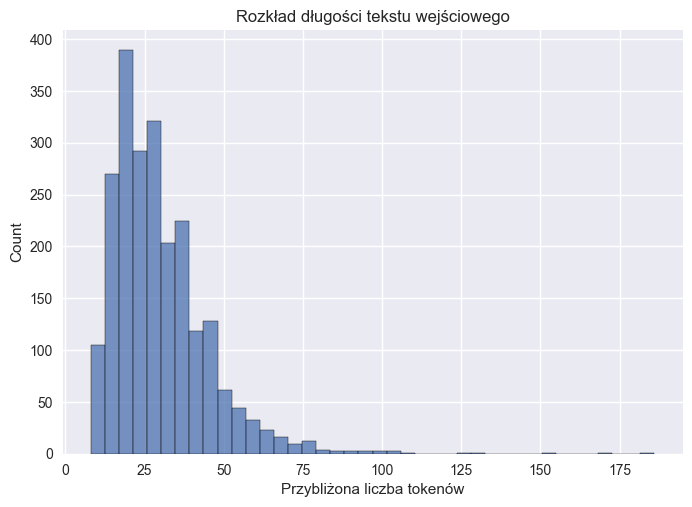

In [14]:
#długość tekstów

full_df["text_len"] = full_df["input_text"].str.split().str.len()

sns.histplot(full_df["text_len"], bins=40)
plt.title("Rozkład długości tekstu wejściowego")
plt.xlabel("Przybliżona liczba tokenów")
plt.show()

Nie ma tu ekstremalnych outlierów;
 same dane nadają się do tokenizacji wraz z uzasadnieniem max_lenght dla transformera.

# Długość odpowiedzi vs jej ocena

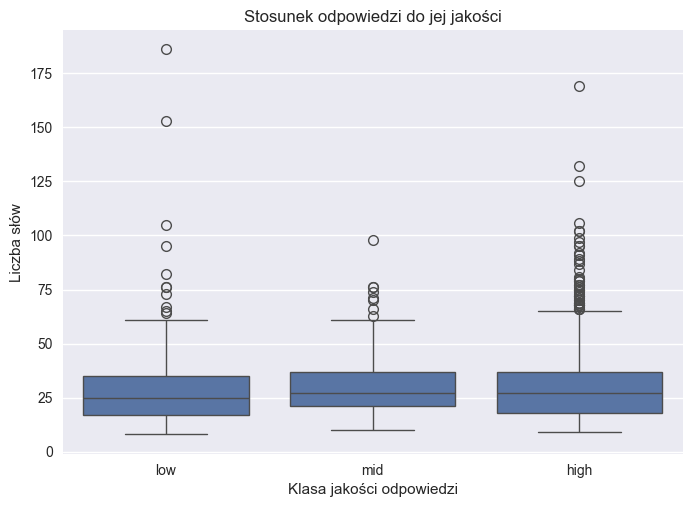

In [15]:
sns.boxplot(
    data=full_df, 
    x="label_name", 
    y="text_len", 
    order=["low", "mid", "high"]
    )
plt.title("Stosunek odpowiedzi do jej jakości")
plt.xlabel("Klasa jakości odpowiedzi")
plt.ylabel("Liczba słów")
plt.show()

Odpowiedzi ocenione wyżej są przeciętnie dłuższe, jednak długość sama w sobie nie determinuje jakości.

In [16]:
for label in ["low", "mid", "high"]:
    print(f"\nPRZYKŁAD DLA: {label.upper()}\n")
    display(
        full_df[full_df["label_name"] == label]
        .sample(2, random_state=67)[["question", "student_answer", "score_avg"]]
    )



PRZYKŁAD DLA: LOW



,question,student_answer,score_avg
1940,How many dimensions need to be specified when ...,"at least 2, depending on how many arrays are b...",2.5
1906,How can you implement a queue with a list?,You can use list to represent the items in a q...,1.5



PRZYKŁAD DLA: MID



,question,student_answer,score_avg
914,What is the main disadvantage of a doubly-link...,The process of adding and removing Nodes in a ...,3.5
1184,What is the role of a header-file?,create a comon area to contain reusable functi...,3.0



PRZYKŁAD DLA: HIGH



,question,student_answer,score_avg
2065,What is the difference between an array declar...,A static local array exists for the duration o...,5.0
1071,What is a linked list?,A linked list is a data structure that is not ...,5.0


## Wnioski z analizy EDA

- Uśredniona ocena jakości (`score_avg`) jest wyrażona w skali 0–5,
  co wymagało korekty początkowych założeń dotyczących progów jakości.
- Na tej podstawie zdefiniowano trzy klasy jakości: low (0–2),
  mid (3) oraz high (4–5).
- Dane zawierają wyraźne różnice jakościowe pomiędzy odpowiedziami,
  widoczne zarówno w analizie ilościowej, jak i jakościowej.
- Długość odpowiedzi koreluje z jakością, ale nie jest determinantem, co uzasadnia zastosowanie tu metod NLP.
- Zbiór danych jest odpowiedni do dalszego modelowania z użyciem
  klasycznych metod ML, sieci neuronowych oraz transformerów.
